In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
import tempfile
from PIL import Image
import numpy as np
import gc
import pandas as pd

from skimage.metrics import structural_similarity as ssim

import time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import numpy as np
import gc
import sys
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict


## **Face Extraction: Orginal Videos**

Note: Using OpenCV & SSIM from SKlearn, These sometimes fetch some blank frame without faces, we need to manually checkup & remove those for further process. in 5fps

In [ ]:
def og_video_to_face(df,start_index = 0,end_index=1000,video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/', destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/',fps=5):
  video_files = sorted([f for f in os.listdir(video_folder_path) if os.path.isfile(video_folder_path + f)])[start_index:end_index]

  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  #df = pd.DataFrame(columns = ['file','image_index','x','y','x+w','y+h'])

  df_index = 0

  for video in video_files:
    cap = cv2.VideoCapture(video_folder_path+video)
    frame_intervals = int(cap.get(cv2.CAP_PROP_FPS)/fps)

    print(video)

    frame_indices = range(0,int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),frame_intervals)
    img_index = 0

    os.makedirs(destination_path+video[:-4], exist_ok=True)

    for i in frame_indices:
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      faces = face_classifier.detectMultiScale(gray_image, minNeighbors=5, minSize=(20, 20))
      if len(faces) != 0:
        x,y,w,h = faces[0]
        face = cv2.resize(frame[y:y+h,x:x+w], (256, 256))

        wp = destination_path+video[:-4]+'/'+f'{img_index:05}'+'.png'
        cv2.imwrite(wp, face)

        df.loc[df_index] = [video[:-4],f'{img_index:05}',x,y,x+w,y+h]
      else:
        df.loc[df_index] = [video[:-4],f'{img_index:05}',0,0,0,0]

      img_index+=1
      df_index+=1

  return df

In [ ]:
# box_df creating with function call & time tracking...

st=time.time()
box_df = pd.DataFrame(columns = ['file','image_index','x','y','x+w','y+h'])
box_df['file'] = box_df['file'].astype(str)
og_video_to_face(box_df,225,226)
print(time.time()-st)

225.mp4
55.08326244354248


In [ ]:
box_df = pd.read_csv('/content/drive/MyDrive/DeepFake Detection/extracted_frames/face_box.csv')

# box_df.to_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/face_box_225.csv',index = False)

## - - - Important!!! Make Sure to delete non-face images - - -

# Join CSV

In [ ]:
# Path to your directory
csv_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'

# List all files in the directory
all_files = os.listdir(csv_path)

# Filter out CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

# Define a function to extract the starting number from the file name
def extract_number(file_name):
    # Remove prefix and extension, then split by '-'
    parts = file_name.replace("face_box_", "").replace(".csv", "").split("-")
    # Convert the first part to an integer
    return int(parts[0])

# Sort files by the extracted number
sorted_files = sorted(csv_files, key=extract_number)

# Print sorted files
# for file in sorted_files:
#     print(file)

print(sorted_files)

['face_box_0.csv', 'face_box_1-49.csv', 'face_box_50.csv', 'face_box_51-99.csv', 'face_box_100.csv', 'face_box_101-149.csv', 'face_box_150.csv', 'face_box_151-199.csv', 'face_box_200.csv', 'face_box_201-224.csv', 'face_box_225.csv', 'face_box_226-249.csv', 'face_box_250.csv', 'face_box_251-299.csv', 'face_box_300.csv', 'face_box_301-349.csv', 'face_box_350.csv', 'face_box_351-399.csv', 'face_box_400-449.csv', 'face_box_450.csv', 'face_box_451-499.csv', 'face_box_500.csv', 'face_box_501-549.csv', 'face_box_550.csv', 'face_box_551-599.csv', 'face_box_600.csv', 'face_box_601-649.csv', 'face_box_650.csv', 'face_box_651-699.csv', 'face_box_700.csv', 'face_box_701-749.csv', 'face_box_750.csv', 'face_box_751-799.csv', 'face_box_800.csv', 'face_box_801-849.csv', 'face_box_850.csv', 'face_box_851-899.csv', 'face_box_900.csv', 'face_box_901-949.csv', 'face_box_950.csv', 'face_box_951-999.csv']


In [ ]:
# Initialize an empty DataFrame to hold the concatenated data
concatenated_df = pd.DataFrame()

# Read and concatenate each file
for file in sorted_files:
    file_path = csv_path + file
    df = pd.read_csv(file_path)
    concatenated_df = pd.concat([concatenated_df, df], ignore_index=True)

# Save the concatenated DataFrame as a new CSV file
output_file = csv_path + 'concatenated_file.csv'
concatenated_df.to_csv(output_file, index=False)

print("Concatenated file saved as 'concatenated_file.csv'")

Concatenated file saved as 'concatenated_file.csv'


# Face Extraction: Manupulated Videos

In [ ]:
def fake_video_to_face(df,video_folder_path, destination_path, fps=5):
  video_files = sorted([f for f in os.listdir(video_folder_path) if os.path.isfile(video_folder_path + f)])
  print(video_files)

  for video in video_files:
    cap = cv2.VideoCapture(video_folder_path+video)

    og_video = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/' + video[:video.find('_')]+'/'
    og_video_frames = sorted([int(f[:-4]) for f in os.listdir(og_video) if os.path.isfile(og_video + f)])
    # print(og_video_frames)

    t = df[df['file']==int(video[:video.find('_')])]
    t = t[t['image_index'].isin(og_video_frames)]

    print(video)

    os.makedirs(destination_path+video[:-4], exist_ok=True)

    for _, i in t.iterrows():
      cap.set(cv2.CAP_PROP_POS_FRAMES, i['image_index'])
      ret, frame = cap.read()

      x,y,xw,yh = i[['x','y','x+w','y+h']]

      face = cv2.resize(frame[y:yh,x:xw], (256, 256))

      wp = destination_path+video[:-4]+'/'+f'{i.image_index:05}'+'.png'
      cv2.imwrite(wp, face)

In [ ]:
box_df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')


In [ ]:
# For DeepFake Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'
  )


['000_003.mp4', '001_870.mp4', '002_006.mp4', '003_000.mp4', '004_982.mp4', '005_010.mp4', '006_002.mp4', '007_132.mp4', '008_990.mp4', '009_027.mp4', '010_005.mp4', '011_805.mp4', '012_026.mp4', '013_883.mp4', '014_790.mp4', '015_919.mp4', '016_209.mp4', '017_803.mp4', '018_019.mp4', '019_018.mp4', '020_344.mp4', '021_312.mp4', '022_489.mp4', '023_923.mp4', '024_073.mp4', '025_067.mp4', '026_012.mp4', '027_009.mp4', '028_068.mp4', '029_048.mp4', '030_193.mp4', '031_163.mp4', '032_944.mp4', '033_097.mp4', '034_590.mp4', '035_036.mp4', '036_035.mp4', '037_072.mp4', '038_125.mp4', '039_058.mp4', '040_997.mp4', '041_063.mp4', '042_084.mp4', '043_110.mp4', '044_945.mp4', '045_889.mp4', '046_904.mp4', '047_862.mp4', '048_029.mp4', '049_946.mp4', '050_059.mp4', '051_332.mp4', '052_108.mp4', '053_095.mp4', '054_071.mp4', '055_147.mp4', '056_996.mp4', '057_070.mp4', '058_039.mp4', '059_050.mp4', '060_088.mp4', '061_080.mp4', '062_066.mp4', '063_041.mp4', '064_991.mp4', '065_089.mp4', '066_062.

In [ ]:
# For Face2Face Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Face2Face/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Face2Face/'
  )


In [ ]:
# For FaceShifter Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceShifter/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceShifter/'
  )


In [ ]:
# For FaceSwap Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceSwap/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceSwap/'
  )


['000_003.mp4', '001_870.mp4', '002_006.mp4', '003_000.mp4', '004_982.mp4', '005_010.mp4', '006_002.mp4', '007_132.mp4', '008_990.mp4', '009_027.mp4', '010_005.mp4', '011_805.mp4', '012_026.mp4', '013_883.mp4', '014_790.mp4', '015_919.mp4', '016_209.mp4', '017_803.mp4', '018_019.mp4', '019_018.mp4', '020_344.mp4', '021_312.mp4', '022_489.mp4', '023_923.mp4', '024_073.mp4', '025_067.mp4', '026_012.mp4', '027_009.mp4', '028_068.mp4', '029_048.mp4', '030_193.mp4', '031_163.mp4', '032_944.mp4', '033_097.mp4', '034_590.mp4', '035_036.mp4', '036_035.mp4', '037_072.mp4', '038_125.mp4', '039_058.mp4', '040_997.mp4', '041_063.mp4', '042_084.mp4', '043_110.mp4', '044_945.mp4', '045_889.mp4', '046_904.mp4', '047_862.mp4', '048_029.mp4', '049_946.mp4', '050_059.mp4', '051_332.mp4', '052_108.mp4', '053_095.mp4', '054_071.mp4', '055_147.mp4', '056_996.mp4', '057_070.mp4', '058_039.mp4', '059_050.mp4', '060_088.mp4', '061_080.mp4', '062_066.mp4', '063_041.mp4', '064_991.mp4', '065_089.mp4', '066_062.

In [ ]:
# For NeuralTextures Folder Face Extraction
fake_video_to_face(
    box_df,
    video_folder_path='/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/NeuralTextures/c23/videos/',
    destination_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/NeuralTextures/'
  )


# Generating Mask

In [ ]:
'''
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/DeepFake/'


# Method 1
src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'


# Method 2
df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')
og_video_folder_path = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/'
src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/'

# Extra
faces = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'
'''


## Method 1: Fast but not so good at perfect mask generating

I will use method 2 not 1

In [ ]:
def mask_generation_1(og_video_path, des_path, src_path):
  videos = sorted([f for f in os.listdir(src_path) if os.path.isdir(src_path+f)])
  for video in videos:
    frames = [f for f in os.listdir(src_path+video)]
    os.makedirs(des_path+video, exist_ok=True)
    print(video)

    for frame in frames:
      df_image = cv2.imread(src_path+video+'/'+frame, cv2.IMREAD_GRAYSCALE)
      og_image = cv2.imread(og_video_path+video[:3]+'/'+frame, cv2.IMREAD_GRAYSCALE)
      _,sim = ssim(df_image, og_image,full=True)

      sim = 1-sim
      sim[sim<=0.2] = 0
      sim*=255
      mask = np.zeros((258,258))
      mask[1:257,1:257] = sim

      wp = des_path+video+'/'+frame
      cv2.imwrite(wp, mask)

  return


In [ ]:
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'


In [ ]:
# Deepfake
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Deepfakes/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/DeepFake/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# Face2Face
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/Face2Face/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Face2Face/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# FaceShifter
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceShifter/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceShifter/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# FaceSwap
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/FaceSwap/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceSwap/'
mask_generation_1(og_video_path, des_path, src_path)


In [ ]:
# NeuralTextures
deepfake_src_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/NeuralTextures/'
des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/NeuralTextures/'
mask_generation_1(og_video_path, des_path, src_path)


## Method 2: Slow But good enough to produce great masks

In [ ]:
def mask_generation_2(df, og_video_path, og_video_folder_path, des_path, src_videos):
    videos = sorted([f for f in os.listdir(src_videos) if os.path.isfile(src_videos+f)])
    for video in videos:
        print(video)

        frames = [f for f in os.listdir(og_video_path+video[:3])]
        cap_og = cv2.VideoCapture(og_video_folder_path+video[:3]+'.mp4')
        cap_d = cv2.VideoCapture(src_videos+video)

        t = df[df['file'] == int(video[:3])]
        os.makedirs(des_path+video[:-4], exist_ok=True)

        for frame in frames:
            frame_index = int(frame[:-4])
            cap_og.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            cap_d.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            _, frame_og = cap_og.read()
            _, frame_d = cap_d.read()
            tt = t[t['image_index'] == frame_index][['x','y','x+w','y+h']]
            x,y,xw,yh = tt.values[0][0],tt.values[0][1],tt.values[0][2],tt.values[0][3]

            og = cv2.cvtColor(frame_og, cv2.COLOR_BGR2GRAY)
            d = cv2.cvtColor(frame_d, cv2.COLOR_BGR2GRAY)

            _,sim = ssim(og[y:yh,x:xw],d[y:yh,x:xw],full=True)
            sim = 1-sim
            sim[sim<=0.2] = 0
            sim*=255
            mask = np.zeros((258,258))
            mask[1:257,1:257] = cv2.resize(sim,(256,256))

            wp = des_path+video[:-4]+'/'+frame[:-4]+'.png'
            cv2.imwrite(wp, mask)
    return


In [ ]:
# Common
og_video_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/og_videos/'
df = pd.read_csv('/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/concatenated_file.csv')
og_video_folder_path = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/original_sequences/youtube/c23/videos/'


In [ ]:
# Deepfake
deepfake_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Deepfakes/'
deepfake_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Deepfakes/c23/videos/'
mask_generation_2(df, og_video_path, og_video_folder_path, des_path=deepfake_des_path, src_videos=deepfake_src_videos)


999_960.mp4


In [ ]:
# Face2Face
Face2Face_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/Face2Face/c23/videos/'
Face2Face_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/Face2Face/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=Face2Face_des_path, src_videos=Face2Face_src_videos)


In [ ]:
# FaceShifter
FaceShifter_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceShifter/c23/videos/'
FaceShifter_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceShifter/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=FaceShifter_des_path, src_videos=FaceShifter_src_videos)


In [ ]:
# FaceSwap
FaceSwap_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/FaceSwap/c23/videos/'
FaceSwap_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/FaceSwap/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=FaceSwap_des_path, src_videos=FaceSwap_src_videos)


In [ ]:
# NeuralTextures
NeuralTextures_src_videos = '/content/drive/MyDrive/DeepFake_Dataset/FaceForensics++/manipulated_sequences/NeuralTextures/c23/videos/'
NeuralTextures_des_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/NeuralTextures/'

mask_generation_2(df, og_video_path, og_video_folder_path, des_path=NeuralTextures_des_path, src_videos=NeuralTextures_src_videos)


602_397.mp4
603_575.mp4
604_703.mp4
605_591.mp4
606_567.mp4
607_683.mp4
608_675.mp4
609_596.mp4
610_692.mp4
611_760.mp4
612_702.mp4
613_685.mp4
614_616.mp4
615_687.mp4
616_614.mp4
617_566.mp4
618_629.mp4
619_620.mp4
620_619.mp4
621_546.mp4
622_647.mp4
623_630.mp4
624_570.mp4
625_650.mp4
626_562.mp4
627_658.mp4
628_568.mp4
629_618.mp4
630_623.mp4
631_551.mp4
632_548.mp4
633_529.mp4
634_660.mp4
635_642.mp4
636_578.mp4
637_427.mp4
638_640.mp4
639_841.mp4
640_638.mp4
641_662.mp4
642_635.mp4
643_646.mp4
644_657.mp4
645_688.mp4
646_643.mp4
647_622.mp4
648_654.mp4
649_816.mp4
650_625.mp4
651_835.mp4
652_773.mp4
653_601.mp4
654_648.mp4
655_444.mp4
656_666.mp4
657_644.mp4
658_627.mp4
659_749.mp4
660_634.mp4
661_670.mp4
662_641.mp4
663_231.mp4
664_668.mp4
665_679.mp4
666_656.mp4
667_446.mp4
668_664.mp4
669_682.mp4
670_661.mp4
671_677.mp4
672_720.mp4
673_728.mp4
674_744.mp4
675_608.mp4
676_776.mp4
677_671.mp4
678_460.mp4
679_665.mp4
680_486.mp4
681_711.mp4
682_669.mp4
683_607.mp4
684_717.mp4
685_

# Look Up Table Generation


In [ ]:
def sample_df(path,frame_count,index,video_index,video_title,vtype,label,df):
  num_of_frames = len(os.listdir(path))
  sample_count = (num_of_frames+frame_count-1)//frame_count

  for i in range(sample_count):
    current_fc = min(frame_count, num_of_frames - i*frame_count)
    df.loc[index+i] = [index+i, video_index, video_title, vtype, label, i, current_fc]
  return index+sample_count


def type_sample_df(path,frame_count,index,video_index,vtype,label,df):
  folders = sorted([f for f in os.listdir(path) if os.path.isdir(path+'/'+f)])
  for i in range(len(folders)):
    index = sample_df(path+'/'+folders[i],frame_count,index,video_index+i,folders[i],vtype,label,df)
  return index, video_index+len(folders)


def all_sample_df(path,frame_count):
  df = pd.DataFrame(columns = ['sample_index','video_index','video_title','video_type','type_label', 'part_num','part_frames'])
  folders = sorted([f for f in os.listdir(path) if os.path.isdir(path+f)])
  index, video_index = 0, 0
  for i in range(len(folders)):
    index, video_index = type_sample_df(path+folders[i],frame_count,index,video_index,i,folders[i],df)
  return df



In [ ]:
extracted_frames_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'

In [ ]:
# Generate Look-up if not exist
# lookup_tabel = all_sample_df(path= extracted_frames_path, frame_count=20)
# lookup_tabel.to_csv(extracted_frames_path + 'lookup_table.csv', index=False)  # Set index=False if you don't want to save row indices


In [ ]:
# Load Look-up if already exist
lookup_tabel = pd.read_csv(extracted_frames_path + 'lookup_table.csv')


In [ ]:
lookup_tabel.tail()


,sample_index,video_index,video_title,video_type,type_label,part_num,part_frames
24806,24806,5439,998,5,og_videos,1,20
24807,24807,5439,998,5,og_videos,2,16
24808,24808,5440,999,5,og_videos,0,20
24809,24809,5440,999,5,og_videos,1,20
24810,24810,5440,999,5,og_videos,2,9


In [ ]:
def sample_by_index(sample_index,frame_count,look_up_table,path,path_mask):
  t = look_up_table.iloc[sample_index]

  path += t.type_label +'/'+ t.video_title
  #  path_mask += t.type_label +'/'+ t.video_title

  frame_names = sorted([f for f in os.listdir(path)])

  imgs = np.zeros((frame_count,256,256,3),dtype=np.uint8)
  #masks = np.zeros((258,258,frame_count),dtype=np.float32)

  for i in range(t.part_frames):
    img = Image.open(path+'/'+frame_names[t.part_num*frame_count+i])
    imgs[i,:,:,:] = np.array(img)
    # if(t.type_label != 'og_videos'):
    #   mask = Image.open(path_mask+'/'+frame_names[t.part_num*frame_count+i])
    #   masks[:,:,i] = np.array(mask)

  label = np.zeros(6,dtype=np.uint8)
  label[t.video_type] = 1
  return imgs, label



In [ ]:
def sample_gen(indices,frame_count,look_up_table,path,path_mask):
  for i in indices:
    yield sample_by_index(i, frame_count, look_up_table, path, path_mask)


# Train Test Split

In [ ]:
video_train_indices, video_test_indices = train_test_split(range(5441), test_size = 0.2, random_state=10)

train_lookup_table = lookup_tabel[lookup_tabel.video_index.isin(video_train_indices)]
test_lookup_table = lookup_tabel[lookup_tabel.video_index.isin(video_test_indices)]

train_indices = train_lookup_table[train_lookup_table['part_frames'] == 20]['sample_index'].tolist()
train_indices = shuffle(train_indices, random_state=50)

test_indices = test_lookup_table[test_lookup_table['part_frames'] == 20]['sample_index'].tolist()


In [ ]:
len(test_indices)


3940

In [ ]:
x = lookup_tabel[lookup_tabel.sample_index.isin(test_indices)]

for i in range(6):
    print(x[x['video_type'] == i]['type_label'].iloc[0], ' = ', len(x[x['video_type'] == i]))


Deepfakes  =  538
Face2Face  =  686
FaceShifter  =  501
FaceSwap  =  697
NeuralTextures  =  806
og_videos  =  712


In [ ]:
extracted_frames_path = '/content/drive/MyDrive/DeepFake_Dataset/extracted_frames/'
mask_path = '/content/drive/MyDrive/DeepFake_Dataset/Mask/'
fc = 20


In [ ]:
len(train_indices)

15810

In [ ]:
start_of_train_sample = 0
end_of_train_sample = 160

dataset = tf.data.Dataset.from_generator(
    lambda: sample_gen(train_indices[start_of_train_sample : end_of_train_sample], fc, lookup_tabel, extracted_frames_path, mask_path),
    output_signature=(
        tf.TensorSpec(shape=(fc, 256, 256, 3), dtype=tf.float32),  # Corrected shape for images
        tf.TensorSpec(shape=(6,), dtype=tf.float32)  # Assuming 'label' is a one-hot encoded vector of length 6
    )
)


# Image into Numpy Array: save in drive

In [ ]:
# Define the shape and data type
shape = (15810, 20, 256, 256, 3)  # total shape of train sample
label = np.zeros((15810, 6), dtype=np.uint8)

# Calculate the number of bytes needed
total_bytes = np.prod(shape) * np.dtype(np.uint8).itemsize
print(f"Total space needed: {total_bytes/1024/1024/1024} GB")


Total space needed: 57.89794921875 GB


In [ ]:
train_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample.npy'
train_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/label.npy'


In [ ]:
# ================ !!! Caution !!! =====================
'''
# Ensure the directory exists
os.makedirs(os.path.dirname(train_sample_path), exist_ok=True)

# Open or create the file and ensure it is the correct size
with open(train_sample_path, 'wb') as f:
    f.seek(total_bytes - 1)
    f.write(b'\0')  # This expands the file to the correct size with zero initialization

'''


In [ ]:
# Memory map the file
train_memory_map = np.memmap(train_sample_path, dtype=np.uint8, mode='r+', shape=shape)
label = np.load(train_label_path)


In [ ]:
j = 14000
for i in train_indices[14000:]:
    train_memory_map[j], label[j] = sample_by_index(i, fc, lookup_tabel, extracted_frames_path, mask_path)
    j += 1
    print(j)

train_memory_map.flush()
del train_memory_map

np.save(train_label_path, label)


In [ ]:
for i in range(14000, 15810):
    if np.sum(train_memory_map[i]) == 0:
        print('train_memory_map = ', i)
        break
    if np.sum(label[i]) == 0:
        print('label = ', i)
        break

    print(i)


In [ ]:
sample_by_index(train_indices[14100], fc, lookup_tabel, extracted_frames_path, mask_path)


# Memory Map to Numpy Array

In [ ]:
shape = (15810, 20, 256, 256, 3)
train_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample.npy'

sample = np.memmap(train_sample_path, dtype=np.uint8, mode='r', shape=shape)




In [ ]:
array_sample = np.array(sample)


In [ ]:
sample_array_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample_array.npy'
np.save(sample_array_path, array_sample)



# Load Memory Map for Training & Testing

In [ ]:
sample_array_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/sample_array.npy'
train_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/label.npy'

sample = np.load(sample_array_path, mmap_mode='r')
label = np.load(train_label_path)

# Testing
test_sample_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/test_sample.npy'
test_label_path = '/content/drive/MyDrive/DeepFake_Dataset/data_as_numpyArray/test_label.npy'

test_sample = np.load(test_sample_path, mmap_mode='r')
test_label = np.load(test_label_path)


# Model Architecture

In [ ]:
class my_Conv3d(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0, bias=False):
    super(my_Conv3d, self).__init__()

    self.conv = nn.Conv3d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
    self.norm = nn.BatchNorm3d(out_ch)
    self.relu = nn.ReLU(inplace = True)

  def forward(self,x):
    return self.relu(self.norm(self.conv(x)))

class inception_block_norm(nn.Module):
  def __init__(self, in_ch, filters):
    super(inception_block_norm, self).__init__()

    self.conv1_direct = my_Conv3d(in_ch, filters[0], kernel_size=1)

    self.conv1_3 = my_Conv3d(in_ch, filters[1], kernel_size=1)
    self.conv3 = my_Conv3d(filters[1], filters[2], kernel_size=3, padding=1)

    self.conv1_5 = my_Conv3d(in_ch, filters[3], kernel_size=1)
    self.conv5 = my_Conv3d(filters[3], filters[4], kernel_size=5, padding=2)

    self.pool = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)
    self.conv1_after_pool = my_Conv3d(in_ch, filters[5], kernel_size=1)

  def forward(self, x):
    direct = self.conv1_direct(x)

    out3 = self.conv3(self.conv1_3(x))
    out5 = self.conv5(self.conv1_5(x))

    pool_conv = self.conv1_after_pool(self.pool(x))

    out = torch.cat([direct, out3, out5, pool_conv], dim=1)

    return out

class inception_net_norm(nn.Module):
  def __init__(self, in_ch=3):
    super(inception_net_norm, self).__init__()

    self.conv7_0 = my_Conv3d(in_ch, 64, kernel_size=7, stride=2, padding=3)
    self.conv1_0 = my_Conv3d(64, 64, kernel_size=1, stride=1, padding=0)
    self.conv3_0 = my_Conv3d(64, 192, kernel_size=3, stride=1, padding=1)

    self.ib_3a = inception_block_norm(192,[64,96,128,16,32,32])
    self.ib_3b = inception_block_norm(256,[128,128,192,32,96,64])

    self.ib_4a = inception_block_norm(480,[192,96,208,16,48,64])
    self.ib_4b = inception_block_norm(512,[160,112,224,24,64,64])
    self.ib_4c = inception_block_norm(512,[128,128,256,24,64,64])
    self.ib_4d = inception_block_norm(512,[112,144,288,32,64,64])
    self.ib_4e = inception_block_norm(528,[256,160,320,32,128,128]) # out_ch 832

    self.ib_5a = inception_block_norm(832,[256,160,320,32,128,128])
    self.ib_5b = inception_block_norm(832,[384,192,384,48,128,128]) #out ch 1024

    self.avg_pool = nn.AvgPool3d(kernel_size = (1,8,8), stride = 1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, 6)

    self.pool= nn.MaxPool3d(kernel_size=3, stride = 2, padding=1)

  def forward(self, x):
    x = self.pool(self.conv7_0(x))
    x = self.conv1_0(x)
    x = self.pool(self.conv3_0(x))

    x = self.ib_3b(self.ib_3a(x))
    x = self.pool(x)

    x = self.ib_4b(self.ib_4a(x))
    x = self.ib_4e(self.ib_4d(self.ib_4c(x)))
    x = self.pool(x)

    x = self.ib_5b(self.ib_5a(x))
    x = self.avg_pool(x)

    x = self.dropout(x)
    x = self.fc1(x.view(-1, 1024))

    return x


In [ ]:
my = inception_net_norm()


## Visulize Model Architecture

In [ ]:
from torchsummary import summary
summary(my, (3, 20, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 10, 128, 128]          65,856
       BatchNorm3d-2     [-1, 64, 10, 128, 128]             128
              ReLU-3     [-1, 64, 10, 128, 128]               0
         my_Conv3d-4     [-1, 64, 10, 128, 128]               0
         MaxPool3d-5        [-1, 64, 5, 64, 64]               0
            Conv3d-6        [-1, 64, 5, 64, 64]           4,096
       BatchNorm3d-7        [-1, 64, 5, 64, 64]             128
              ReLU-8        [-1, 64, 5, 64, 64]               0
         my_Conv3d-9        [-1, 64, 5, 64, 64]               0
           Conv3d-10       [-1, 192, 5, 64, 64]         331,776
      BatchNorm3d-11       [-1, 192, 5, 64, 64]             384
             ReLU-12       [-1, 192, 5, 64, 64]               0
        my_Conv3d-13       [-1, 192, 5, 64, 64]               0
        MaxPool3d-14       [-1, 192, 3,

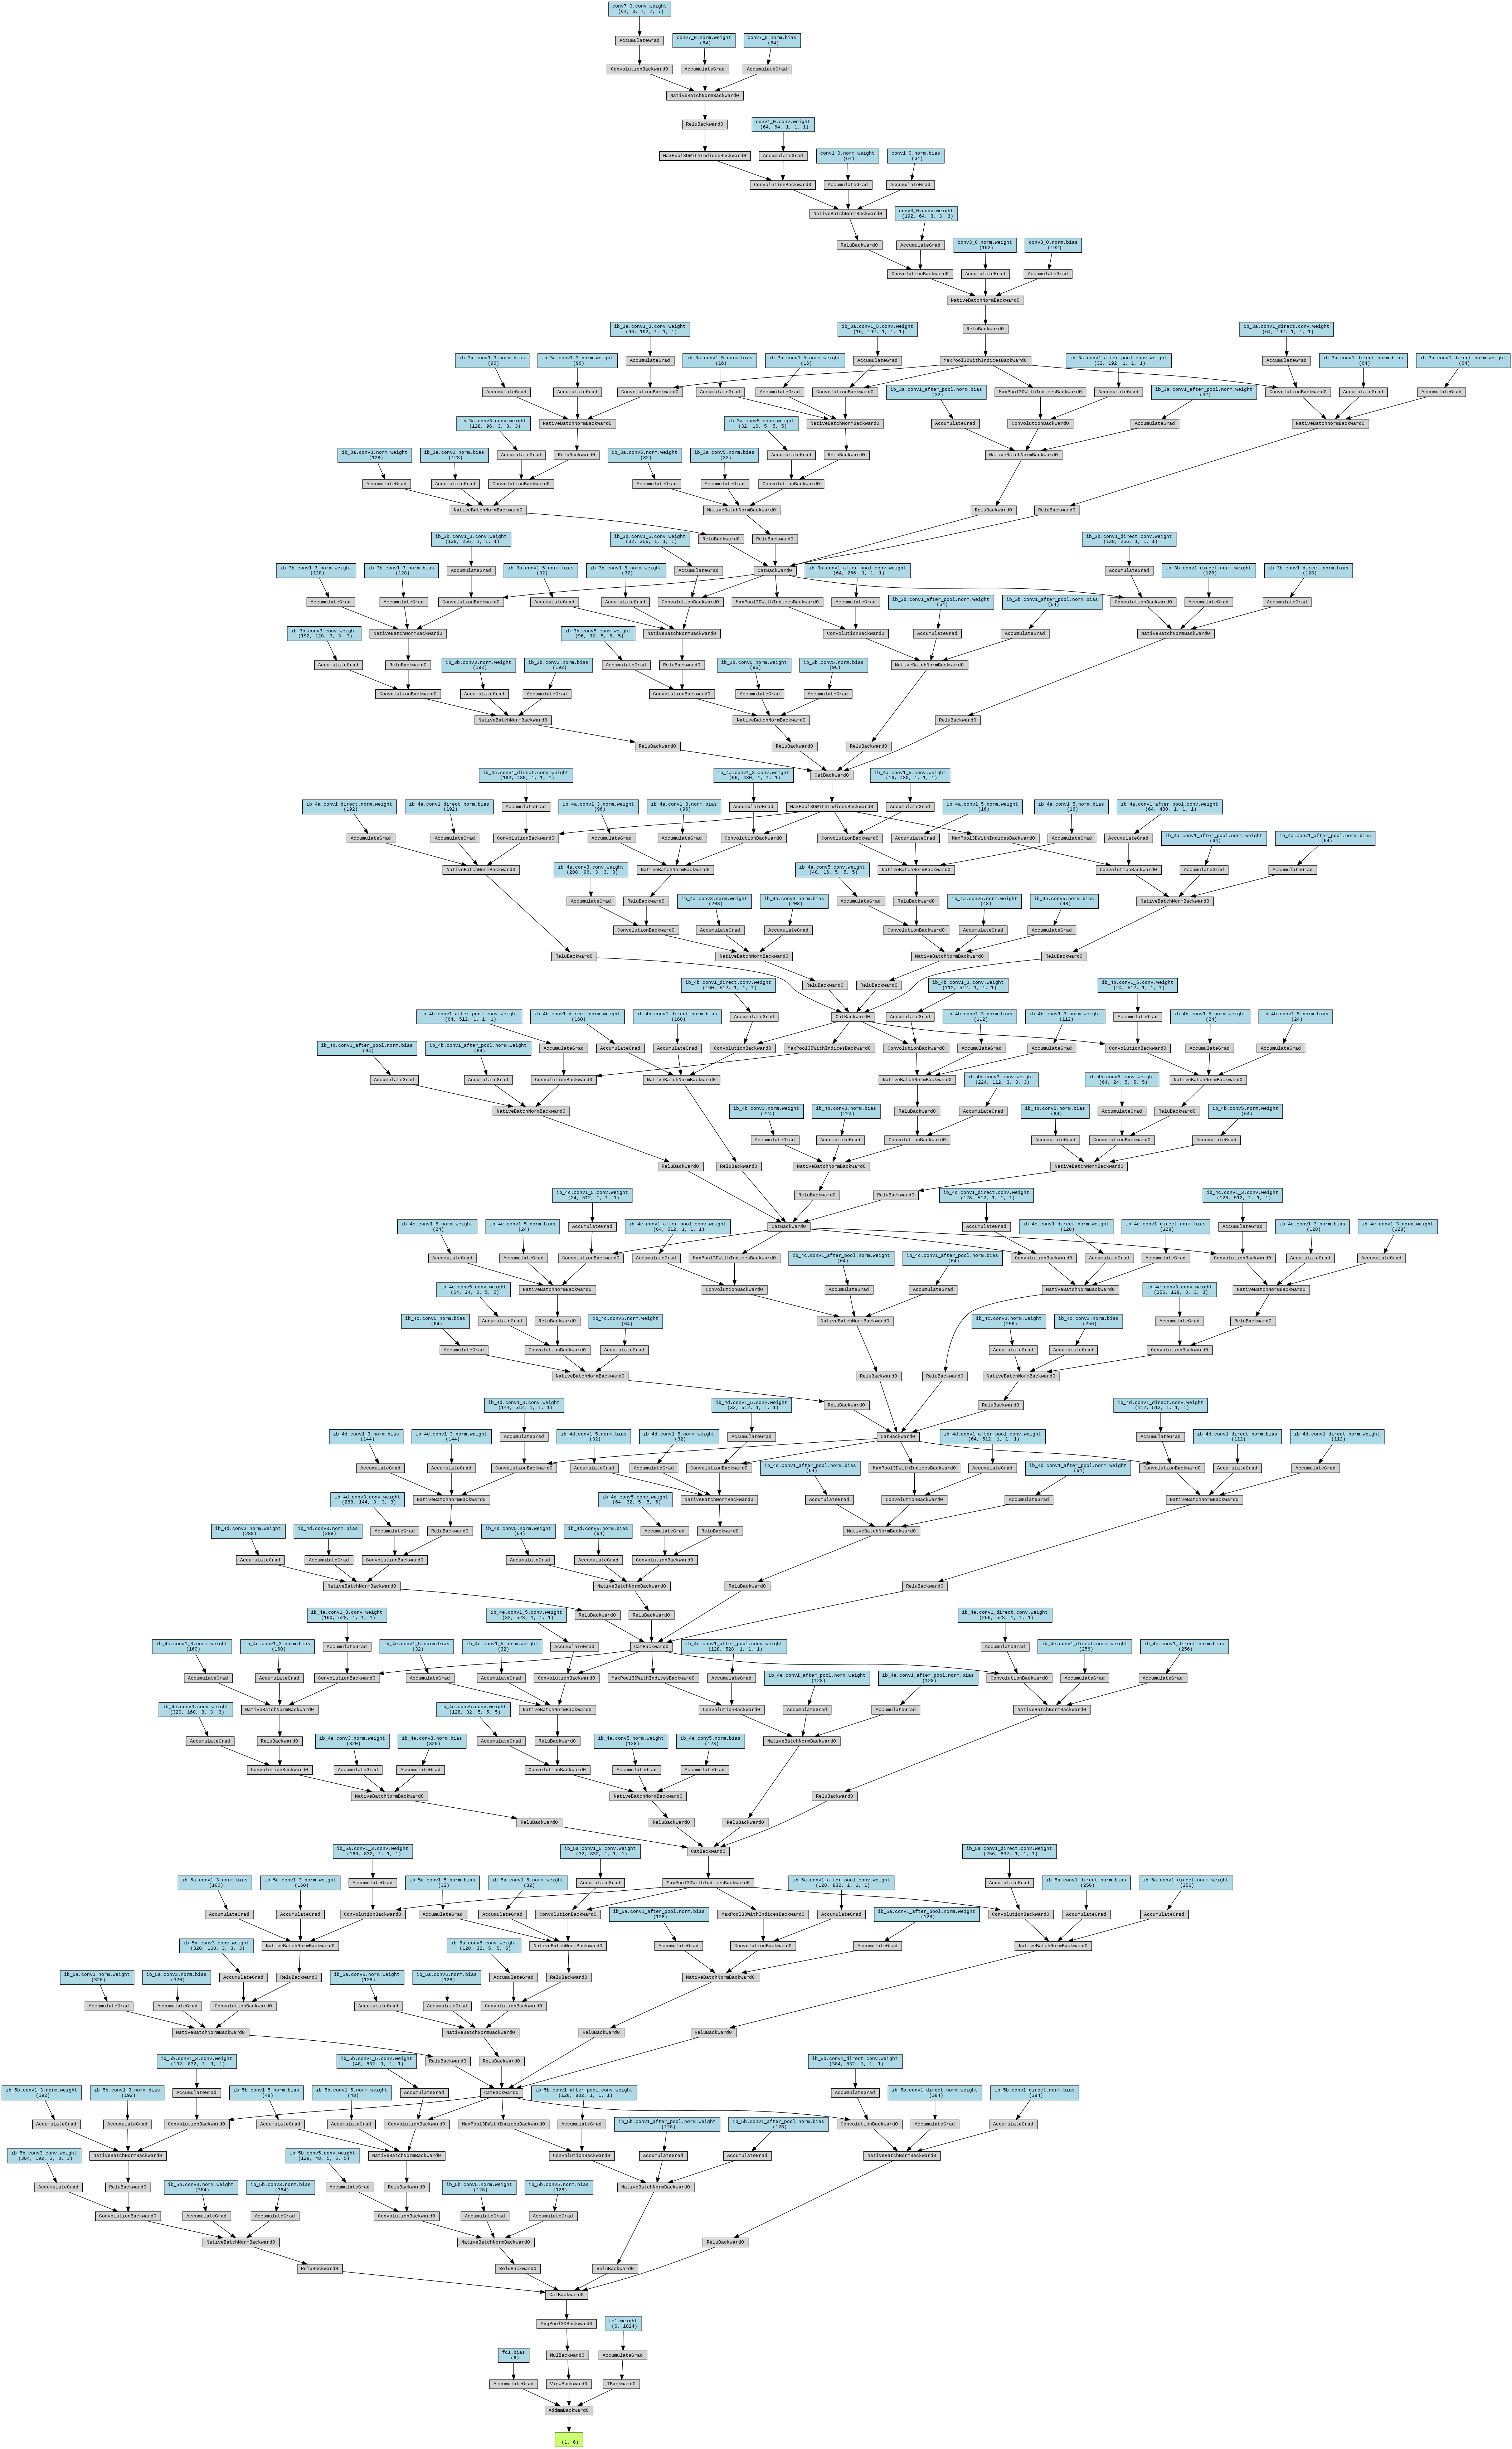

In [ ]:
import torch
from torchviz import make_dot
import torch
import hiddenlayer as hl

model = inception_net_norm()
dummy_input = torch.randn(1, 3, 20, 256, 256)
output = model(dummy_input)

# Visualize the graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("inception_net_norm", format="png")
cv2_imshow(cv2.imread("inception_net_norm.png"))


# Training Setup

In [ ]:
class my_Dataset(Dataset):
    def __init__(self, samples, labels, indices=None, transform=None):
        self.samples = samples
        self.indices = indices
        self.labels = np.argmax(labels,axis=1)
        self.transform = transform

    def __len__(self):
        if self.indices is None:
            return self.samples.shape[0]
        return self.indices.shape[0]

    def __getitem__(self, idx):
        if self.indices is None:
            sample = torch.from_numpy(np.copy(self.samples[idx])).permute(3, 0, 1, 2).float()/255.0
            label = self.labels[idx]
            return sample, label

        sample = torch.from_numpy(np.copy(self.samples[self.indices[idx]])).permute(3, 0, 1, 2).float()/255.0
        label = self.labels[self.indices[idx]]

        return sample, label


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my = my.to(device)


In [ ]:
my_optimizer = optim.Adam(my.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()


In [ ]:
# Validaition set: from test data
# train_index_start = 0
# train_index_end = 2000

train_dataset = my_Dataset(sample, label)
train_data = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)

test_dataset = my_Dataset(test_sample, test_label)
test_data = DataLoader(test_dataset, batch_size=36, shuffle=True, num_workers=0)

validation_data = test_data


In [ ]:
torch.cuda.empty_cache()


In [ ]:
gc.collect()


0

# Training Loop

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%5 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/10 Loss: 1.769519 Accuracy: 0.26250 epoch_time: 360.06s
Epoch   2/10 Loss: 1.546510 Accuracy: 0.33000 epoch_time: 216.17s
Epoch   3/10 Loss: 1.475468 Accuracy: 0.34550 epoch_time: 205.33s
Epoch   4/10 Loss: 1.448615 Accuracy: 0.35550 epoch_time: 201.96s
Epoch   5/10 Val_Loss: 1.462667 Val_Accuracy: 0.33883
Epoch   5/10 Loss: 1.425116 Accuracy: 0.34800 epoch_time: 677.57s
Epoch   6/10 Loss: 1.406273 Accuracy: 0.34900 epoch_time: 211.02s
Epoch   7/10 Loss: 1.402963 Accuracy: 0.35250 epoch_time: 207.57s
Epoch   8/10 Loss: 1.386023 Accuracy: 0.35950 epoch_time: 206.74s
Epoch   9/10 Loss: 1.385736 Accuracy: 0.36850 epoch_time: 207.53s
Epoch  10/10 Val_Loss: 1.420383 Val_Accuracy: 0.34721
Epoch  10/10 Loss: 1.366665 Accuracy: 0.36950 epoch_time: 475.74s


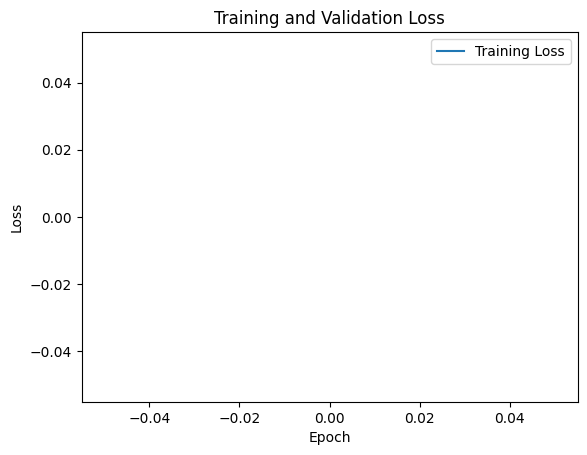

In [ ]:
epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(val_epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my.pth'

torch.save(my.state_dict(), model_path)


In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
# already Done 10 epoch

num_epochs = 110
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%5 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/110 Loss: 1.368728 Accuracy: 0.36100 epoch_time: 197.06s
Epoch   2/110 Loss: 1.357516 Accuracy: 0.35550 epoch_time: 207.42s
Epoch   3/110 Loss: 1.336934 Accuracy: 0.37250 epoch_time: 211.07s
Epoch   4/110 Loss: 1.370921 Accuracy: 0.34650 epoch_time: 207.75s
Epoch   5/110 Val_Loss: 1.674561 Val_Accuracy: 0.28655
Epoch   5/110 Loss: 1.342746 Accuracy: 0.37850 epoch_time: 489.46s
Epoch   6/110 Loss: 1.338373 Accuracy: 0.37300 epoch_time: 206.05s
Epoch   7/110 Loss: 1.336076 Accuracy: 0.38400 epoch_time: 213.51s
Epoch   8/110 Loss: 1.327751 Accuracy: 0.39400 epoch_time: 210.35s
Epoch   9/110 Loss: 1.308695 Accuracy: 0.37950 epoch_time: 210.08s
Epoch  10/110 Val_Loss: 1.482587 Val_Accuracy: 0.34442
Epoch  10/110 Loss: 1.330581 Accuracy: 0.39800 epoch_time: 489.78s
Epoch  11/110 Loss: 1.319070 Accuracy: 0.39100 epoch_time: 207.19s
Epoch  12/110 Loss: 1.317929 Accuracy: 0.39100 epoch_time: 208.88s
Epoch  13/110 Loss: 1.314144 Accuracy: 0.39800 epoch_time: 209.79s
Epoch  14/110 Loss:

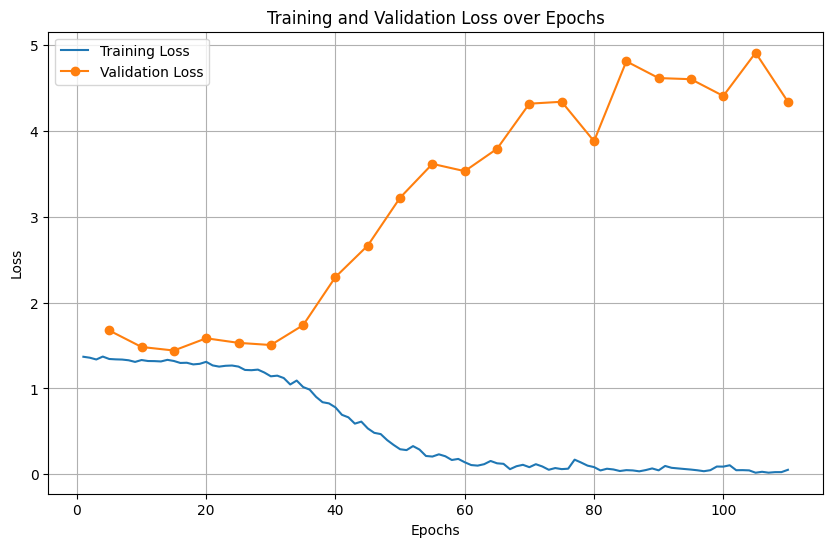

In [ ]:
# Training loss and accuracy data
epochs = list(range(1, 111))
loss = [
    1.368728, 1.357516, 1.336934, 1.370921, 1.342746, 1.338373, 1.336076,
    1.327751, 1.308695, 1.330581, 1.319070, 1.317929, 1.314144, 1.332766,
    1.319580, 1.296633, 1.298940, 1.279697, 1.286491, 1.309709, 1.267898,
    1.253961, 1.263573, 1.266697, 1.254237, 1.215300, 1.212224, 1.218996,
    1.185120, 1.141126, 1.148707, 1.120977, 1.046076, 1.091618, 1.016128,
    0.986612, 0.901949, 0.839753, 0.825882, 0.779263, 0.692946, 0.663577,
    0.590370, 0.613817, 0.534580, 0.483324, 0.468698, 0.398370, 0.342318,
    0.292210, 0.282297, 0.328795, 0.288665, 0.213826, 0.207251, 0.233205,
    0.210583, 0.167163, 0.179685, 0.140916, 0.108235, 0.101598, 0.118300,
    0.155837, 0.128578, 0.122512, 0.060369, 0.094452, 0.111107, 0.083597,
    0.118205, 0.091822, 0.053416, 0.073370, 0.060968, 0.065873, 0.171081,
    0.137723, 0.101550, 0.084673, 0.045535, 0.065443, 0.056969, 0.038807,
    0.049088, 0.045871, 0.035277, 0.049769, 0.068899, 0.046606, 0.097952,
    0.076153, 0.069107, 0.062230, 0.055644, 0.047306, 0.036632, 0.048535,
    0.091043, 0.089931, 0.105807, 0.048190, 0.049127, 0.046268, 0.019015,
    0.029924, 0.019547, 0.025663, 0.025997, 0.053010
]

# Validation loss data
val_loss_epochs = list(range(5, 111, 5))
val_loss = [
    1.674561, 1.482587, 1.441209, 1.583806, 1.530498, 1.505306, 1.736608,
    2.296916, 2.663186, 3.220065, 3.613750, 3.528804, 3.789287, 4.314301,
    4.336412, 3.877627, 4.807183, 4.612218, 4.599127, 4.403916, 4.907244, 4.336412
]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(val_loss_epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# already Done 120 epoch on 2k sample

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%2 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/20 Loss: 1.339745 Accuracy: 0.48665 epoch_time: 2409.21s
Epoch   2/20 Val_Loss: 1.140049 Val_Accuracy: 0.51193
Epoch   2/20 Loss: 1.100559 Accuracy: 0.55572 epoch_time: 2242.75s
Epoch   3/20 Loss: 0.980340 Accuracy: 0.60196 epoch_time: 1803.60s
Epoch   4/20 Val_Loss: 1.466850 Val_Accuracy: 0.49569
Epoch   4/20 Loss: 0.856430 Accuracy: 0.64972 epoch_time: 2086.97s
Epoch   5/20 Loss: 0.789132 Accuracy: 0.68596 epoch_time: 1782.65s
Epoch   6/20 Val_Loss: 1.364242 Val_Accuracy: 0.52716
Epoch   6/20 Loss: 0.680843 Accuracy: 0.72517 epoch_time: 2078.42s
Epoch   7/20 Loss: 0.601305 Accuracy: 0.75180 epoch_time: 1770.30s
Epoch   8/20 Val_Loss: 1.126788 Val_Accuracy: 0.59569
Epoch   8/20 Loss: 0.517246 Accuracy: 0.78798 epoch_time: 2061.62s
Epoch   9/20 Loss: 0.486638 Accuracy: 0.80474 epoch_time: 1785.07s
Epoch  10/20 Val_Loss: 1.552597 Val_Accuracy: 0.57538
Epoch  10/20 Loss: 0.421965 Accuracy: 0.83194 epoch_time: 2080.35s
Epoch  11/20 Loss: 0.376386 Accuracy: 0.84807 epoch_time: 17

In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_Full.pth'

torch.save(my.state_dict(), model_path)


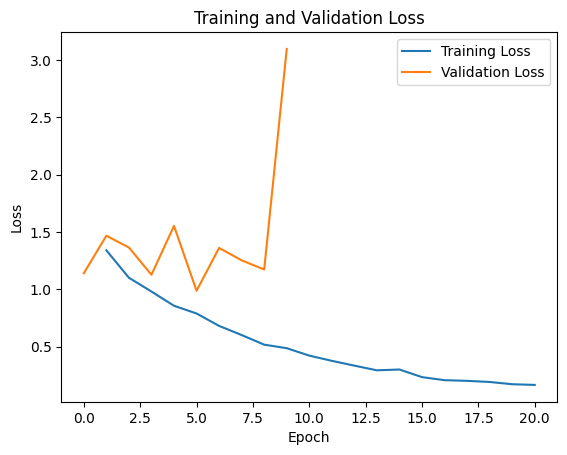

In [ ]:
epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# already Done 120 epoch on 2k sample + 20 epoch on all data

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/5 Val_Loss: 1.368487 Val_Accuracy: 0.65508
Epoch   1/5 Loss: 0.156030 Accuracy: 0.94225 epoch_time: 2136.31s
Epoch   2/5 Val_Loss: 1.532334 Val_Accuracy: 0.62893
Epoch   2/5 Loss: 0.142048 Accuracy: 0.94744 epoch_time: 2144.49s
Epoch   3/5 Val_Loss: 1.300587 Val_Accuracy: 0.68731
Epoch   3/5 Loss: 0.138377 Accuracy: 0.95206 epoch_time: 2138.14s
Epoch   4/5 Val_Loss: 2.227225 Val_Accuracy: 0.61142
Epoch   4/5 Loss: 0.128979 Accuracy: 0.95332 epoch_time: 2148.74s
Epoch   5/5 Val_Loss: 1.771562 Val_Accuracy: 0.60660
Epoch   5/5 Loss: 0.127994 Accuracy: 0.95408 epoch_time: 2130.05s


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_Full1.pth'

torch.save(my.state_dict(), model_path)


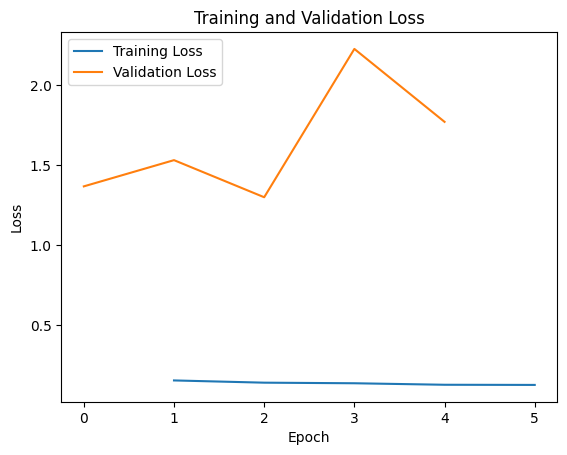

In [ ]:
epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Conditional Training: for Neural Texture & Face Shifter Imbalance

In [ ]:
NeuralTexture_indices = np.where(np.argmax(label, axis=1) == 4)[0].tolist()
FaceShifter_indices = np.where(np.argmax(label, axis=1) == 2)[0].tolist()

print(len(NeuralTexture_indices))
print(len(FaceShifter_indices))

neuraltexture_faceshifter = NeuralTexture_indices + FaceShifter_indices
print(len(neuraltexture_faceshifter))

neuraltexture_faceshifter = np.array(neuraltexture_faceshifter)


2871
2302
5173


In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_Full1.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
# Validaition set: from test data

train_dataset = my_Dataset(sample, label, indices = neuraltexture_faceshifter)
train_data = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)

test_dataset = my_Dataset(test_sample, test_label)
test_data = DataLoader(test_dataset, batch_size=36, shuffle=True, num_workers=0)

validation_data = test_data


In [ ]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/5 Val_Loss: 1.386255 Val_Accuracy: 0.70457
Epoch   1/5 Loss: 0.488151 Accuracy: 0.86024 epoch_time: 1560.93s
Epoch   2/5 Val_Loss: 1.398747 Val_Accuracy: 0.69416
Epoch   2/5 Loss: 0.070166 Accuracy: 0.97912 epoch_time: 887.02s
Epoch   3/5 Val_Loss: 1.515235 Val_Accuracy: 0.68426
Epoch   3/5 Loss: 0.033975 Accuracy: 0.99188 epoch_time: 897.22s
Epoch   4/5 Val_Loss: 1.597079 Val_Accuracy: 0.68046
Epoch   4/5 Loss: 0.026953 Accuracy: 0.99246 epoch_time: 915.86s
epoch: 5 batch: 5 loss: 0.047128 accuracy: 0.99444 time: 2.59s

KeyboardInterrupt: 

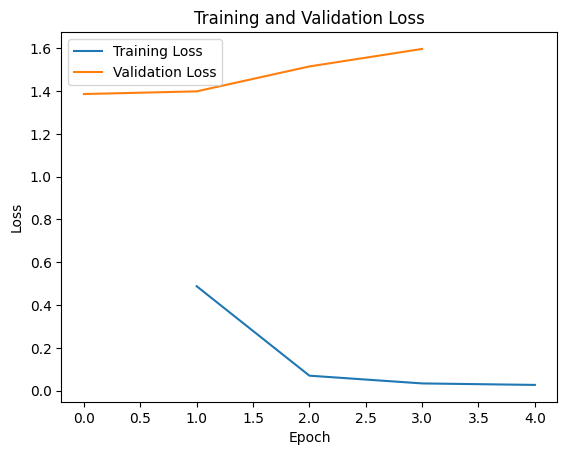

In [ ]:
epochs = range(1, len(train_losses) + 1)  # Epochs for train_losses
val_epochs = range(5, len(train_losses) + 1, 5)  # Epochs for val_losses (every 5th epoch)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_neural_face.pth'

torch.save(my.state_dict(), model_path)


In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 1.602876, Accuracy: 0.682741


[[332   9  40  26 131   0]
 [ 20 232  12  14 407   1]
 [  9   7 354  23 108   0]
 [  9  13  27 515 132   1]
 [ 21  58 101  36 590   0]
 [  0   0  16   6  23 667]]


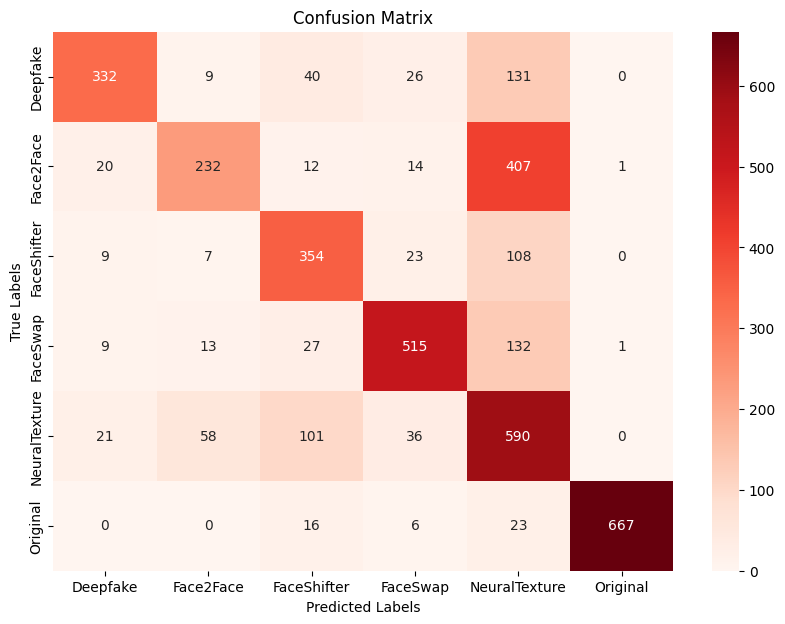

In [ ]:
conf_matrix1 = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix1[all_labels[i]][all_pred[i]] += 1

print(conf_matrix1)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data1 = conf_matrix1

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data1, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix1.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



# Again De Normalizing with full dataset and low epoch

In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_neural_face.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
num_epochs = 2
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/2 Val_Loss: 1.291412 Val_Accuracy: 0.72563
Epoch   1/2 Loss: 0.031761 Accuracy: 0.98944 epoch_time: 2094.08s
Epoch   2/2 Val_Loss: 1.388061 Val_Accuracy: 0.73046
Epoch   2/2 Loss: 0.016499 Accuracy: 0.99437 epoch_time: 2108.47s


In [ ]:
# model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_neural_face_balance.pth'
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_condition2_balance.pth'

torch.save(my.state_dict(), model_path)


In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 1.329757, Accuracy: 0.723350


[[387  17  45  26  63   0]
 [ 45 392  16  25 205   3]
 [ 14  16 388  13  70   0]
 [ 17  24  29 580  43   4]
 [ 48 163 121  62 408   4]
 [  2   0   4   5   6 695]]


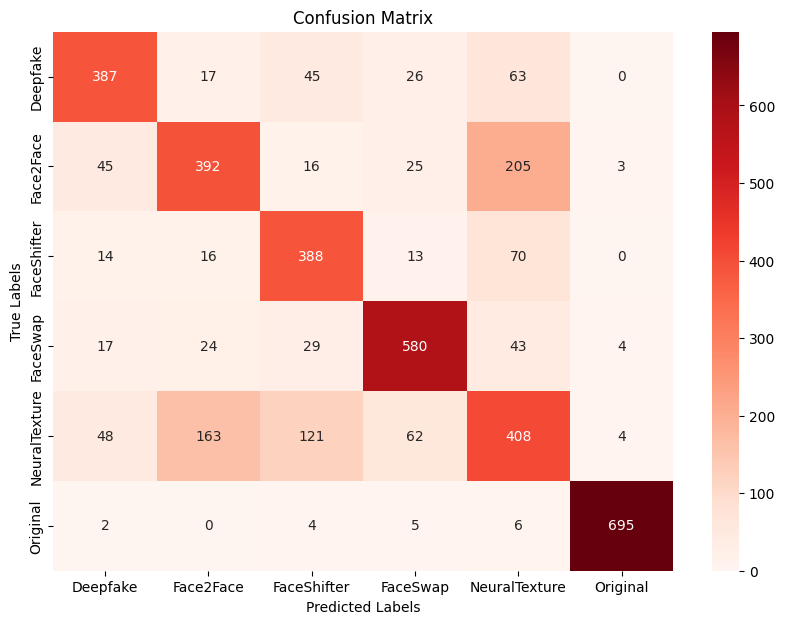

In [ ]:
conf_matrix1 = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix1[all_labels[i]][all_pred[i]] += 1

print(conf_matrix1)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data1 = conf_matrix1

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data1, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix1.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



In [ ]:
# Conditional training 2

my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 1.389210, Accuracy: 0.730457


[[390  24  35  18  71   0]
 [ 39 400  13  17 215   2]
 [ 14  15 368   9  94   1]
 [ 23  28  26 564  54   2]
 [ 40 158  93  50 462   3]
 [  2   1   4   4   7 694]]


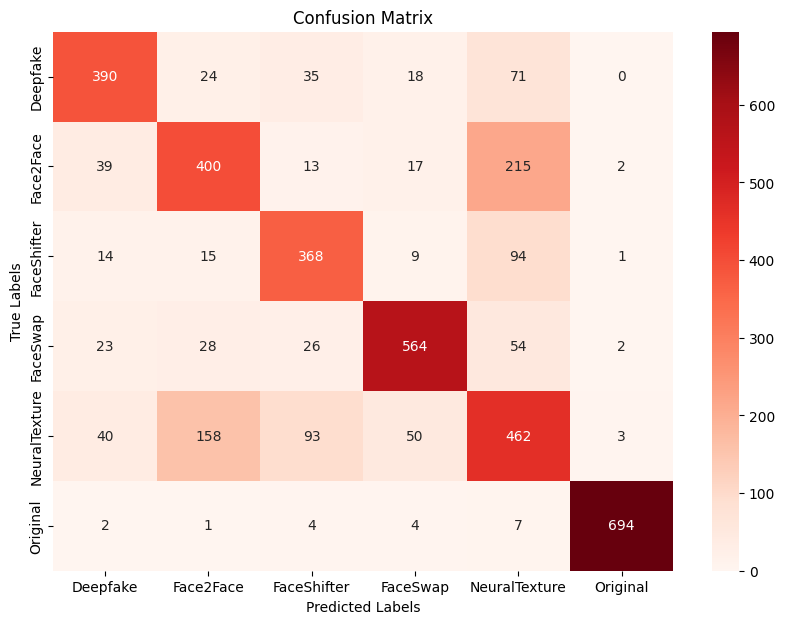

In [ ]:
conf_matrix1 = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix1[all_labels[i]][all_pred[i]] += 1

print(conf_matrix1)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data1 = conf_matrix1

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data1, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix1.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



In [ ]:
# Conditional training 2

my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in train_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 0.039417, Accuracy: 0.996458


[[2242    0    1    1    4    0]
 [   0 2435    0    0    9    0]
 [   1    2 2294    0    3    2]
 [   9    2    0 2961    7    1]
 [   8    3    0    0 2860    0]
 [   1    1    0    1    0 2962]]


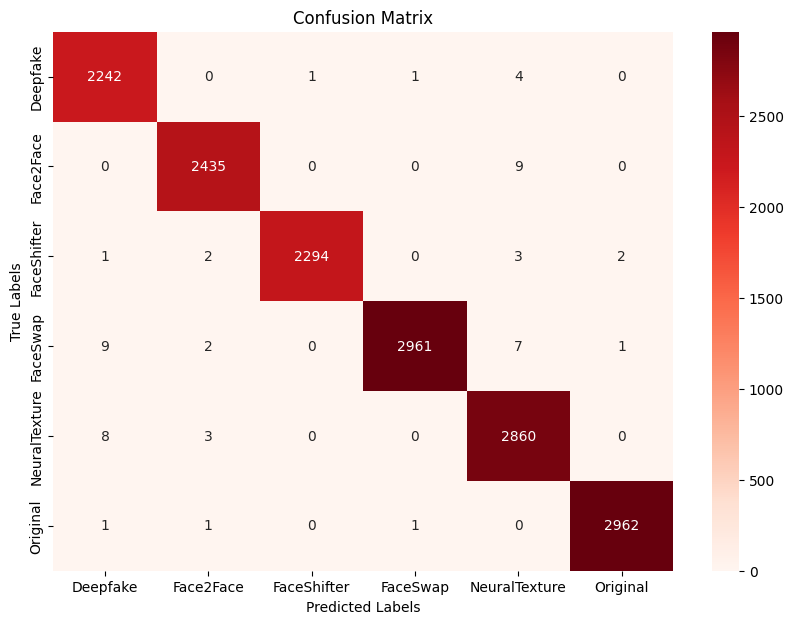

In [ ]:
conf_matrix1 = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix1[all_labels[i]][all_pred[i]] += 1

print(conf_matrix1)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data1 = conf_matrix1

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data1, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix1.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in train_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 0.061135, Accuracy: 0.994877


[[2239    0    2    3    3    1]
 [   2 2429    2    2    9    0]
 [   0    0 2298    0    2    2]
 [   9    1    2 2965    2    1]
 [   8   23    1    1 2838    0]
 [   0    0    1    4    0 2960]]


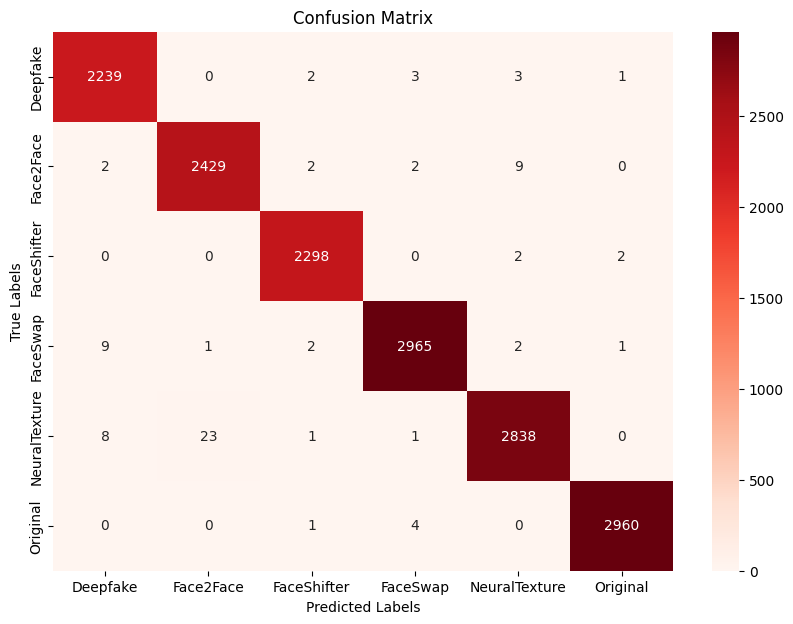

In [ ]:
conf_matrix1 = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix1[all_labels[i]][all_pred[i]] += 1

print(conf_matrix1)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data1 = conf_matrix1

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data1, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix1.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



#Conditional Training 2: Neural texture & Face2Face



0 = Deepfakes

1 = Face2Face

2 = FaceShifter

3 = FaceSwap

4 = NeuralTextures

5 = og_videos

In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_neural_face_balance.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
NeuralTexture_indices = np.where(np.argmax(label, axis=1) == 4)[0].tolist()
Face2face_indices = np.where(np.argmax(label, axis=1) == 1)[0].tolist()

print(len(NeuralTexture_indices))
print(len(Face2face_indices))

neuraltexture_face2face = NeuralTexture_indices + Face2face_indices
print(len(neuraltexture_face2face))

neuraltexture_face2face = np.array(neuraltexture_face2face)


2871
2444
5315


In [ ]:
# Validaition set: from test data

train_dataset = my_Dataset(sample, label, indices = neuraltexture_face2face)
train_data = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=0)

test_dataset = my_Dataset(test_sample, test_label)
test_data = DataLoader(test_dataset, batch_size=36, shuffle=True, num_workers=0)

validation_data = test_data


In [ ]:
num_epochs = 4
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    my.train()
    running_loss = 0.0
    correct = 0
    total = 0
    se = time.time()
    for i, data in enumerate(train_data, 0):
        sb = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        my_optimizer.zero_grad()

        outputs = my(inputs)
        loss = loss_func(outputs, labels)

        loss.backward()
        my_optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sys.stdout.write('\repoch: %d batch: %d loss: %.6f accuracy: %.5f time: %.2fs' %(epoch + 1, i + 1, batch_loss ,correct / total, time.time()-sb))
        sys.stdout.flush()



    my.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    if (epoch+1)%1 == 0:
        with torch.no_grad():  # No gradient computation during validation
            for val_data in validation_data:
                val_inputs, val_labels = val_data
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = my(val_inputs)
                val_loss += loss_func(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        print('\rEpoch %3d/%d Val_Loss: %.6f Val_Accuracy: %.5f' %(epoch + 1, num_epochs, val_loss / len(validation_data), val_correct / val_total))
        val_losses.append(val_loss / len(validation_data))
    train_losses.append(running_loss / len(train_data))

    # Calculate accuracy for the whole epoch
    print('\rEpoch %3d/%d Loss: %.6f Accuracy: %.5f epoch_time: %.2fs' %(epoch + 1, num_epochs, running_loss / len(train_data), correct / total, time.time()-se))


Epoch   1/4 Val_Loss: 1.713406 Val_Accuracy: 0.70914
Epoch   1/4 Loss: 0.246020 Accuracy: 0.92361 epoch_time: 2007.75s
Epoch   2/4 Val_Loss: 1.679651 Val_Accuracy: 0.69340
Epoch   2/4 Loss: 0.047912 Accuracy: 0.98457 epoch_time: 832.56s
Epoch   3/4 Val_Loss: 1.868931 Val_Accuracy: 0.68376
Epoch   3/4 Loss: 0.031583 Accuracy: 0.99003 epoch_time: 855.62s
Epoch   4/4 Val_Loss: 2.198658 Val_Accuracy: 0.65939
Epoch   4/4 Loss: 0.028783 Accuracy: 0.99003 epoch_time: 866.04s


In [ ]:
model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_conditional2.pth'

torch.save(my.state_dict(), model_path)


In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 2.190321, Accuracy: 0.659391


In [ ]:
conf_matrix = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix[all_labels[i]][all_pred[i]] += 1

print(conf_matrix)



[[362  20  33  19 104   0]
 [ 24 391   9  17 245   0]
 [ 13  14 312  13 149   0]
 [ 23  25  26 528  94   1]
 [ 32 146  69  44 513   2]
 [  1 167   4   2  46 492]]


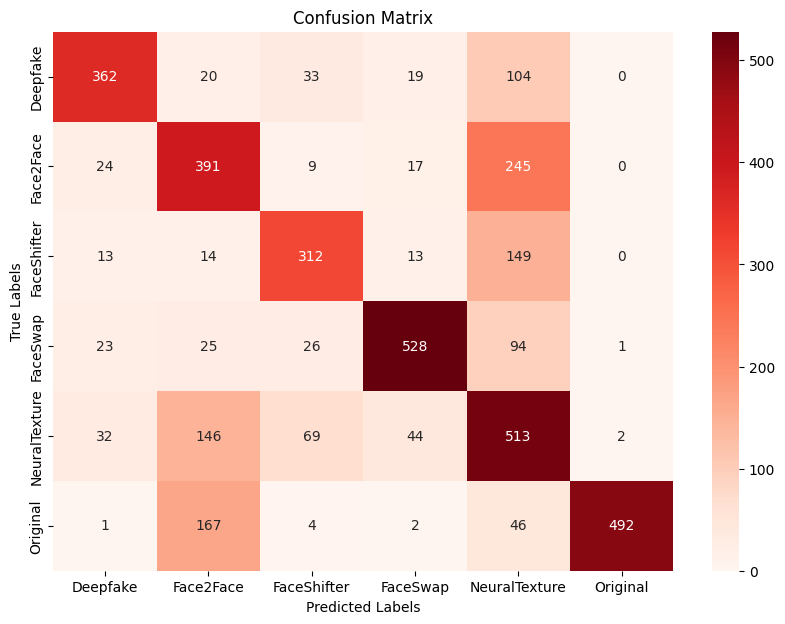

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for the confusion matrix
confusion_matrix_data = conf_matrix

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()



# Testing

In [ ]:
# my = inception_net_norm()

model_path = '/content/drive/MyDrive/DeepFake_Dataset/saved_model_v13(Inception_pytorch)/my_neural_face_balance.pth'
# Load saved model parameters into the model
my.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
my.eval()

criterion = nn.CrossEntropyLoss()

# Initialize variables for computing metrics
total_loss = 0.0
correct = 0
total = 0

all_pred = []
all_labels = []

# Iterate over evaluation dataset
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_data:
        all_labels.extend(labels.numpy())
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = my(inputs)
        loss = criterion(outputs, labels)

        # Accumulate loss
        total_loss += loss.item()

        # Compute predictions
        _, predicted = torch.max(outputs, 1)
        all_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute average loss
average_loss = total_loss / len(test_data)

# Compute accuracy
accuracy = correct / total

print(f'Evaluation Loss: {average_loss:.6f}, Accuracy: {accuracy:.6f}')


Evaluation Loss: 1.332852, Accuracy: 0.723350


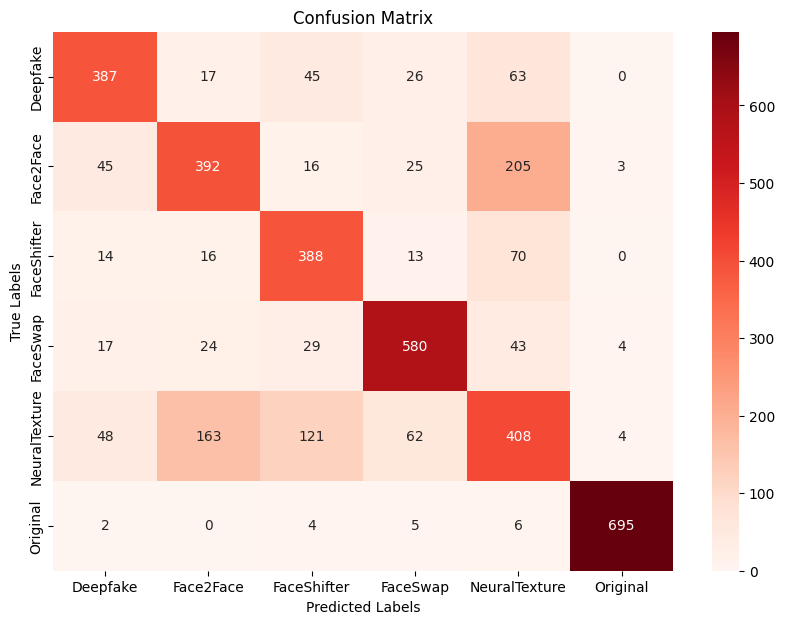

In [ ]:
conf_matrix = np.zeros((6, 6), dtype=np.uint16)
for i in range(len(all_pred)):
    conf_matrix[all_labels[i]][all_pred[i]] += 1

# Data for the confusion matrix
confusion_matrix_data = conf_matrix

# Class names for the labels
class_names = ['Deepfake', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTexture', 'Original']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)  # Adjust dpi for higher or lower quality

plt.show()


0  =  Deepfakes

1  =  Face2Face

2  =  FaceShifter

3  =  FaceSwap

4  =  NeuralTextures

5  =  og_videos